# Postprocessing a FNN Trained for a Mass-Spring-Damper System 

In [1]:
### Loading Libraries

import os
import sys
import numpy                              as np
import pandas                             as pd

import matplotlib
from matplotlib                           import pyplot as plt
WORKSPACE_PATH  = os.environ['WORKSPACE_PATH']
plt.style.use(WORKSPACE_PATH+'/ROMNet/romnet/extra/postprocessing/presentation.mplstyle')

from tensorflow                           import keras

import romnet                             as rmnt

In [2]:
### Input Data

jPOD          = 0

ROMNet_fld    = WORKSPACE_PATH + '/ROMNet/romnet/'
path_to_run_fld  = WORKSPACE_PATH + '/ROMNet/MSD_100Cases_POD_'+str(jPOD+1)+'_Branch_ICs/FNN/Deterministic/Run_1/'
#path_to_run_fld  = WORKSPACE_PATH + '/ROMNet/MSD_100Cases_POD_1_Branch/FNN_BbB/Deterministic/Run_1/'
#path_to_run_fld  = WORKSPACE_PATH + '/ROMNet/MSD_10Cases/FNN/BayesByBackprop/Run_2/'

TrainingCases = [0]#[0,2,4,6,8]
TestCases     = [0,2,4]#[0,2]

NSamples      = 100

Nt            = 100
tout          = np.linspace(0.,15.,Nt)
SOLVER        = 'Radau'

LineTypeVec   = ['-',':','--','.-']*10

In [3]:
print("\n[ROMNet]: Reading Input File from: ", path_to_run_fld)
sys.path.insert(0, path_to_run_fld)

print("\n[ROMNet]: Keep Loading Modules and Functions...")
from ROMNet_Input import inputdata

print("\n[ROMNet]: Initializing Input ...")
InputData               = inputdata(WORKSPACE_PATH, ROMNet_fld)


InputData.InputFilePath = path_to_run_fld+'/ROMNet_Input.py'
InputData.train_int_flg   = 0
InputData.path_to_run_fld  = path_to_run_fld


[ROMNet]: Reading Input File from:  /Users/sventuri/WORKSPACE//ROMNet/MSD_100Cases_POD_1_Branch_ICs/FNN/Deterministic/Run_1/

[ROMNet]: Keep Loading Modules and Functions...

[ROMNet]: Initializing Input ...


In [4]:
surrogate_type = InputData.surrogate_type
if (surrogate_type == 'FNN-SourceTerms'):
    surrogate_type = 'FNN'

Net   = getattr(rmnt.nn, surrogate_type)

model = rmnt.model.Model_Deterministic(InputData)

model.build(InputData, None, Net)

NN    = model.net


[ROMNet]:   Initializing the ML Model

[ROMNet]:   Building the ML Model

[ROMNet]:   Loading ML Model Parameters from File:  /Users/sventuri/WORKSPACE//ROMNet/MSD_100Cases_POD_1_Branch_ICs/FNN/Deterministic/Run_1//Training/Params//004142.h5
'load_params' took 0.014481 s


[ROMNet]:   Saving ML Model Parameters to File:  /Users/sventuri/WORKSPACE//ROMNet/MSD_100Cases_POD_1_Branch_ICs/FNN/Deterministic/Run_1//Model/Params/Initial.h5
'save_params' took 0.011425 s

'build' took 0.949101 s



Text(0, 0.5, '$\\alpha_{x_2}$, from FNN')

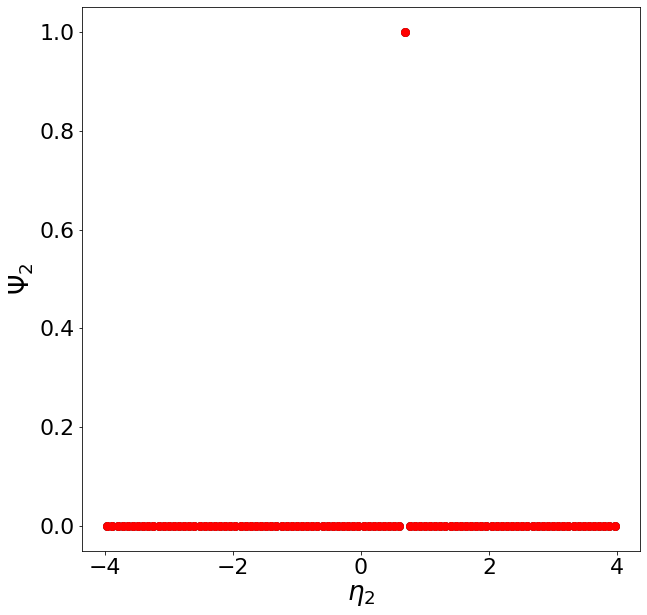

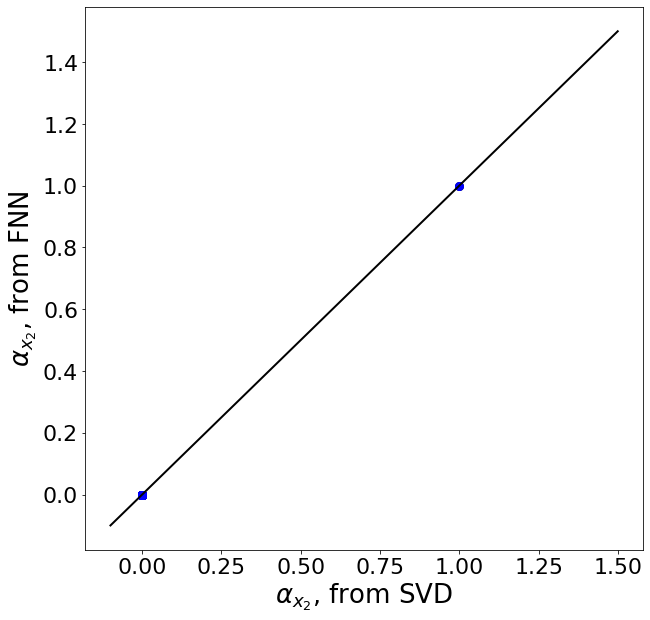

In [5]:
### Evaluating on Test Data

iVar       = 1

VarOI     = 'IC_99'

Vars      = ['IC_'+str(i_mode+1) for i_mode in range(InputData.n_modes)]

FileName   = InputData.path_to_data_fld + '/test/ext/Input.csv'# + InputData.InputFile
DataIn     = pd.read_csv(FileName, header=0)
Input      = DataIn.to_numpy()
VarNames   = list(DataIn.columns)

FileName   = InputData.path_to_data_fld + '/test/ext/Output.csv'# + InputData.InputFile
Data       = pd.read_csv(FileName, header=0)
Output     = Data.to_numpy()

FileName   = InputData.path_to_data_fld + '/train/pts/Input.csv'# + InputData.InputFile
DataIn     = pd.read_csv(FileName, header=0)
InputTrain = DataIn.to_numpy()
VarNames   = list(DataIn.columns)

FileName   = InputData.path_to_data_fld + '/train/pts/Output.csv'# + InputData.InputFile
Data       = pd.read_csv(FileName, header=0)
OutputTrain= Data.to_numpy()

FileName   = InputData.path_to_data_fld + '/valid/pts/Input.csv'# + InputData.InputFile
DataIn     = pd.read_csv(FileName, header=0)
InputValid = DataIn.to_numpy()
VarNames   = list(DataIn.columns)

FileName   = InputData.path_to_data_fld + '/valid/pts/Output.csv'# + InputData.InputFile
Data       = pd.read_csv(FileName, header=0)
OutputValid= Data.to_numpy()

## Variable to Be Visualized
for i_mode in range(len(Vars)):
    if (Vars[i_mode] == VarOI):
        print('i_mode = ', i_mode)
        break

        
yMat      = model.predict(Input)    
yMatTrain = model.predict(InputTrain)    
yMatValid = model.predict(InputValid)    

plt.figure(figsize=(10,10))
plt.plot(Input[:,iVar], Output[:,i_mode], 'ko')
plt.plot(Input[:,iVar], yMat[:,i_mode], 'ro')
# plt.plot(InputTrain[:,iPC], OutputTrain[:,iVar], 'ko')
# plt.plot(InputTrain[:,iPC], yMatTrain[:,iVar], 'ro')
# plt.plot(InputValid[:,iPC], OutputValid[:,iVar], 'bo')
# plt.plot(InputValid[:,iPC], yMatValid[:,iVar], 'go')
plt.xlabel(r'$\eta_{'+str(iVar+1)+'}$')
plt.ylabel(r'$\Psi_{'+str(i_mode+1)+'}$')
#plt.xlim([1.e-6,1.e-2])
#plt.legend()
#plt.show()

MinFact = 1.e-3
MaxFact = 1.5

plt.figure(figsize=(10,10))
plt.plot(OutputTrain[:,i_mode], yMatTrain[:,i_mode], 'ko')
plt.plot(OutputValid[:,i_mode], yMatValid[:,i_mode], 'bo')
plt.plot([yMatTrain[:,i_mode].min()-0.1, yMatTrain[:,i_mode].max()*MaxFact],[yMatTrain[:,i_mode].min()-0.1, yMatTrain[:,i_mode].max()*MaxFact], 'k-')
plt.xlabel(r'$\alpha_{x_'+str(i_mode+1)+'}$'+', from SVD')
plt.ylabel(r'$\alpha_{x_'+str(i_mode+1)+'}$'+', from FNN')
#plt.xlim([yMatTrain[:,iVar].min()*MinFact, yMatTrain[:,iVar].max()*MaxFact])
#plt.ylim([yMatTrain[:,iVar].min()*MinFact, yMatTrain[:,iVar].max()*MaxFact])

In [6]:
OutputDir = InputData.path_to_data_fld

FileName = OutputDir+'/../ROM/A.csv'
A        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

FileName = OutputDir+'/../ROM/C.csv'
C        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

FileName = OutputDir+'/../ROM/D.csv'
D        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

i_mode =  0


Text(0, 0.5, '$\\alpha_{x_1}$, from FNN')

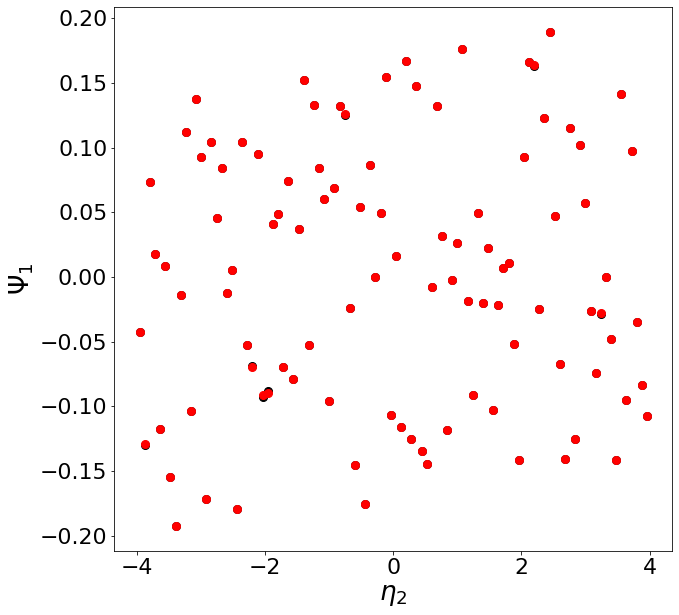

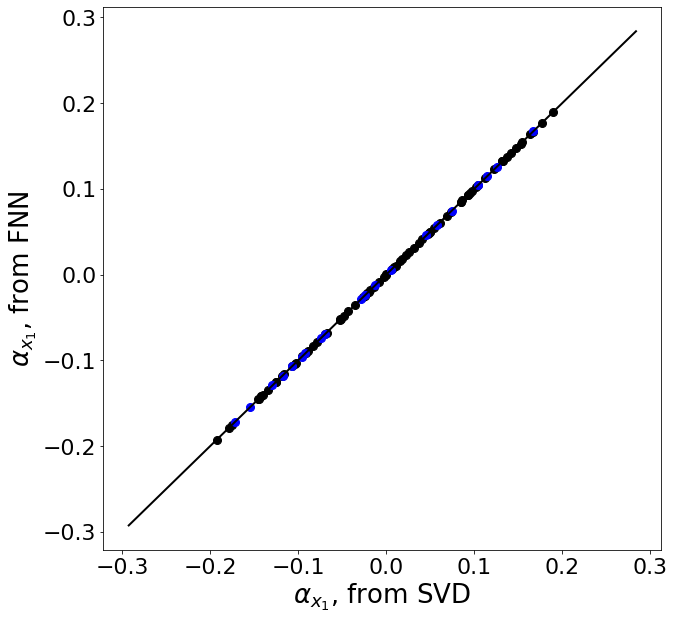

In [7]:
### Evaluating on Test Data

iVar       = 1

VarOI     = 'POD_1'

Vars      = ['POD_'+str(i_mode+1) for i_mode in range(InputData.n_modes)]

path_to_data_fld = InputData.path_to_data_fld + '/../Branch/'

FileName   = path_to_data_fld + '/test/ext/Input.csv'# + InputData.InputFile
DataIn     = pd.read_csv(FileName, header=0)
Input      = DataIn.to_numpy()
VarNames   = list(DataIn.columns)

FileName   = path_to_data_fld + '/test/ext/Output.csv'# + InputData.InputFile
Data       = pd.read_csv(FileName, header=0)
Output     = Data.to_numpy()

FileName   = path_to_data_fld + '/train/pts/Input.csv'# + InputData.InputFile
DataIn     = pd.read_csv(FileName, header=0)
InputTrain = DataIn.to_numpy()
VarNames   = list(DataIn.columns)

FileName   = path_to_data_fld + '/train/pts/Output.csv'# + InputData.InputFile
Data       = pd.read_csv(FileName, header=0)
OutputTrain= Data.to_numpy()

FileName   = path_to_data_fld + '/valid/pts/Input.csv'# + InputData.InputFile
DataIn     = pd.read_csv(FileName, header=0)
InputValid = DataIn.to_numpy()
VarNames   = list(DataIn.columns)

FileName   = path_to_data_fld + '/valid/pts/Output.csv'# + InputData.InputFile
Data       = pd.read_csv(FileName, header=0)
OutputValid= Data.to_numpy()

## Variable to Be Visualized
for i_mode in range(len(Vars)):
    if (Vars[i_mode] == VarOI):
        print('i_mode = ', i_mode)
        break

        
yMat      = model.predict(Input).dot(A.T)
yMatTrain = model.predict(InputTrain).dot(A.T)    
yMatValid = model.predict(InputValid).dot(A.T)    

plt.figure(figsize=(10,10))
plt.plot(Input[:,iVar], Output[:,i_mode], 'ko')
plt.plot(Input[:,iVar], yMat[:,i_mode], 'ro')
# plt.plot(InputTrain[:,iPC], OutputTrain[:,iVar], 'ko')
# plt.plot(InputTrain[:,iPC], yMatTrain[:,iVar], 'ro')
# plt.plot(InputValid[:,iPC], OutputValid[:,iVar], 'bo')
# plt.plot(InputValid[:,iPC], yMatValid[:,iVar], 'go')
plt.xlabel(r'$\eta_{'+str(iVar+1)+'}$')
plt.ylabel(r'$\Psi_{'+str(i_mode+1)+'}$')
#plt.xlim([1.e-6,1.e-2])
#plt.legend()
#plt.show()

MinFact = 1.e-3
MaxFact = 1.5

plt.figure(figsize=(10,10))
plt.plot(OutputTrain[:,i_mode], yMatTrain[:,i_mode], 'ko')
plt.plot(OutputValid[:,i_mode], yMatValid[:,i_mode], 'bo')
plt.plot([yMatTrain[:,i_mode].min()-0.1, yMatTrain[:,i_mode].max()*MaxFact],[yMatTrain[:,i_mode].min()-0.1, yMatTrain[:,i_mode].max()*MaxFact], 'k-')
plt.xlabel(r'$\alpha_{x_'+str(i_mode+1)+'}$'+', from SVD')
plt.ylabel(r'$\alpha_{x_'+str(i_mode+1)+'}$'+', from FNN')
#plt.xlim([yMatTrain[:,iVar].min()*MinFact, yMatTrain[:,iVar].max()*MaxFact])
#plt.ylim([yMatTrain[:,iVar].min()*MinFact, yMatTrain[:,iVar].max()*MaxFact])

Text(0.5, 0, '$\\Psi_{2}$')

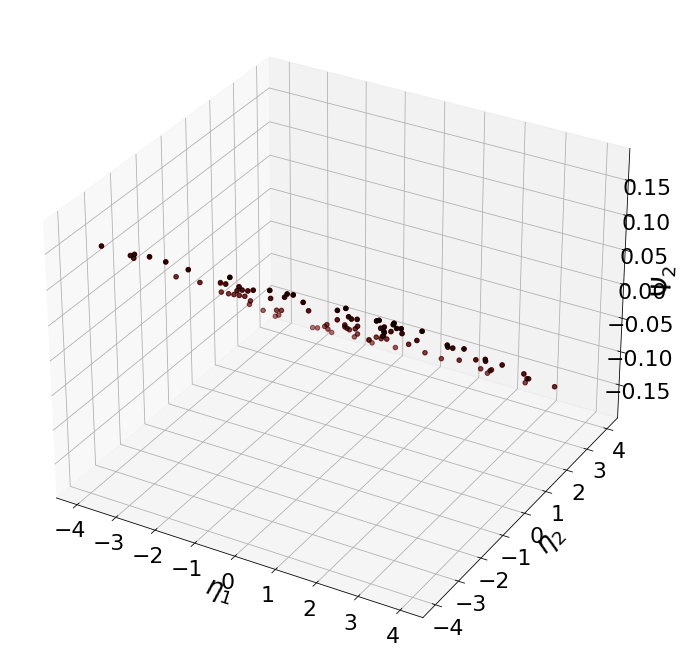

In [8]:
# %matplotlib qt

iVar = 1

fig = plt.figure(figsize=(12,12))
ax  = fig.add_subplot(projection='3d')
ax.scatter(Input[:,0], Input[:,1], Output[:,iVar], c='k')
ax.scatter(Input[:,0], Input[:,1], yMat[:,iVar], c='r')
ax.set_xlabel(r'$\eta_{'+str(1)+'}$')
ax.set_ylabel(r'$\eta_{'+str(2)+'}$')
ax.set_zlabel(r'$\Psi_{'+str(iVar+1)+'}$')

In [9]:
# print('[PCA]  Max % Error = ', np.max(abs((yMat - Output)/yMat)*100))
# print('[PCA]  Max      SE = ', np.max((yMat - Output)**2))
# print('[PCA] Mean % Error = ', np.mean(abs((yMat - Output)/yMat)*100))
# print('[PCA]          MSE = ', np.mean((yMat - Output)**2))

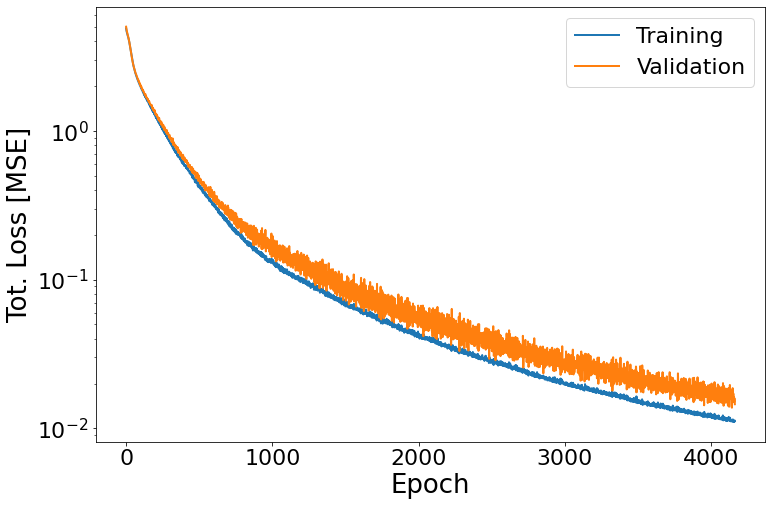

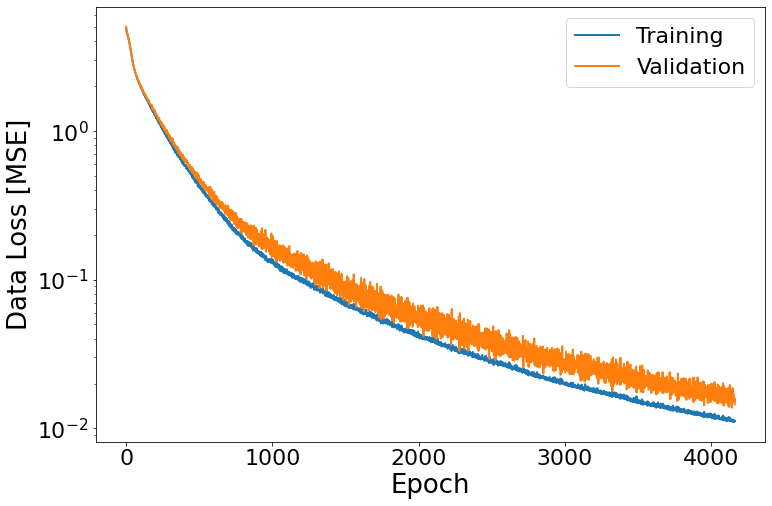

In [10]:
Data    = pd.read_csv(path_to_run_fld+'/Training/History.csv')

# OldRun  = 'Run_39'
# DataOld = pd.read_csv(path_to_run_fld+'/../'+OldRun+'/Training/History.csv')

fig  = plt.figure(figsize=(12,8))
plt.plot(Data['tot_loss'],      label='Training')
plt.plot(Data['val_tot_loss'],  label='Validation')
# plt.plot(DataOld['tot_loss'],     label='Training, '+OldRun)
# plt.plot(DataOld['val_tot_loss'], label='Validation, '+OldRun)
plt.xlabel('Epoch')
plt.ylabel('Tot. Loss [MSE]')
plt.legend()
plt.yscale('log')


fig  = plt.figure(figsize=(12,8))
plt.plot(Data['pts_loss'],      label='Training')
plt.plot(Data['val_pts_loss'],  label='Validation')
# plt.plot(DataOld['pts_loss'],     label='Training, '+OldRun)
# plt.plot(DataOld['val_pts_loss'], label='Validation, '+OldRun)
plt.xlabel('Epoch')
plt.ylabel('Data Loss [MSE]')
plt.legend()
plt.yscale('log')
#plt.ylim([1.e-2, 1.e0])

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['scs_loss'],     label='Training')
# plt.plot(Data['val_scs_loss'], label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('S.C.s Loss [MSE]')
# plt.legend()
# plt.yscale('log')

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['ics_loss'],     label='Training')
# plt.plot(Data['val_ics_loss'], label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('I.C.s Loss [MSE]')
# plt.legend()
# plt.yscale('log')

In [11]:
# import tensorflow as tf

# LName   = 'Trunk_1_HL' + str(len(InputData.ActFun[0]))

# inputs  = tf.keras.Input(shape=(1,))

# Output_ = inputs
# for i in range(len(model.net.FNNLayersVecs[0])):
#     Layer   = model.net.FNNLayersVecs[0][i]
#     Output_ = Layer(Output_)


# Branch = keras.Model(inputs=inputs, outputs=Output_)
# Branch.summary()

In [12]:
# iVar = 1

# SigmaVec = tf.math.softplus(0.05 * Branch.predict(Input)[:,64:])

# fig = plt.figure()
# ax  = fig.add_subplot(projection='3d')
# ax.scatter(Input[:,0], Input[:,1], SigmaVec[:,iVar], c='k')
# ax.set_xlabel(r'$\eta_{'+str(1)+'}$')
# ax.set_ylabel(r'$\eta_{'+str(2)+'}$')
# ax.set_zlabel(r'$\Psi_{'+str(iVar+1)+'}$')

In [13]:
# iVar = 63

# MuVec = Branch.predict(Input)[:,0:64] * model.y_range + model.y_min

# fig = plt.figure()
# ax  = fig.add_subplot(projection='3d')
# ax.scatter(Input[:,0], Input[:,1], Output[:,iVar], c='k')
# ax.scatter(Input[:,0], Input[:,1], MuVec[:,iVar],    c='r')
# ax.set_xlabel(r'$\eta_{'+str(1)+'}$')
# ax.set_ylabel(r'$\eta_{'+str(2)+'}$')
# ax.set_zlabel(r'$\Psi_{'+str(iVar+1)+'}$')

In [14]:
import tensorflow as tf

AA      = np.concatenate([A.T,C], axis=1)

Layer_  = tf.keras.layers.Dense(units              = AA.shape[1],
                                activation         = 'linear',
                                use_bias           = False,
                                name               = 'NN_IC_1_POD')

NNNew   = NN
NNNew.FNNLayersVecs[0].append(Layer_)

input_  = tf.keras.Input(shape=[NNNew.NVarsx,])
net     = tf.keras.Model(inputs=[input_], outputs=[NNNew.call(input_)] )

#net.layers[-1].set_weights([AA, np.zeros((A.shape[0],))])
net.layers[-1].set_weights([AA])

net.layers[-1].weights

[<tf.Variable 'NN_IC_1_POD/kernel:0' shape=(100, 3) dtype=float64, numpy=
 array([[-2.38644556e-02,  2.86722202e-02, -2.01989935e-02],
        [ 1.32041767e-01, -2.50899974e-02,  5.08720524e-02],
        [-1.16076869e-01, -9.04307227e-03, -3.05425164e-02],
        [-7.87644634e-02,  6.49821522e-02, -5.31486357e-02],
        [-1.26280226e-02,  1.12232477e-01, -5.49396401e-02],
        [-8.32658965e-02, -1.70866722e-01,  5.30339155e-02],
        [ 1.59779643e-02, -1.20398672e-03,  5.32059958e-03],
        [ 9.70935936e-02, -1.57961885e-01,  1.01013263e-01],
        [ 1.06214876e-02, -7.76371846e-02,  3.85679181e-02],
        [ 1.02066240e-01, -1.23135482e-01,  8.66204481e-02],
        [ 1.04369223e-01,  1.26505287e-01, -2.65065733e-02],
        [-6.76325629e-02, -1.14890255e-01,  3.21822093e-02],
        [ 7.42279138e-02,  7.35145712e-02, -1.13487987e-02],
        [-4.29089805e-02,  1.70154695e-01, -9.03903595e-02],
        [ 1.12089932e-01,  1.44091822e-01, -3.22188005e-02],
        [-1

In [15]:
import h5py
import tensorflow as tf
from keras    import backend
from keras    import __version__ as keras_version  # pylint: disable=g-import-not-at-top
from keras.saving import saving_utils


def _legacy_weights(layer):
    """DO NOT USE.
    For legacy reason, the layer.weights was in the order of
    [self.trainable_weights + self.non_trainable_weights], and this order was
    used for preserving the weights in h5 format. The new order of layer.weights
    are the same as layer.get_weights() which is more intuitive for user. To
    keep supporting the existing saved h5 file, this method should be used to
    save/load weights. In future version, we will delete this method and
    introduce a breaking change for h5 and stay with the new order for weights.
    Args:
    layer: a `tf.keras.Model` or `tf.keras.layers.Layer` instance.
    Returns:
    A list of variables with the order of trainable_weights, followed by
      non_trainable_weights.
    """
    weights = layer.trainable_weights + layer.non_trainable_weights
    if any(not isinstance(w, tf.Variable) for w in weights):
        raise NotImplementedError(
            f'Save or restore weights that is not an instance of `tf.Variable` is '
            f'not supported in h5, use `save_format=\'tf\'` instead. Received a '
            f'model or layer {layer.__class__.__name__} with weights {weights}')
    return weights



def save_attributes_to_hdf5_group(group, name, data):
    HDF5_OBJECT_HEADER_LIMIT = 64512
    
    bad_attributes = [x for x in data if len(x) > HDF5_OBJECT_HEADER_LIMIT]

    # Expecting this to never be true.
    if bad_attributes:
        raise RuntimeError('The following attributes cannot be saved to HDF5 '
                           'file because they are larger than %d bytes: %s' %
                           (HDF5_OBJECT_HEADER_LIMIT, ', '.join(bad_attributes)))

    data_npy = np.asarray(data)

    num_chunks = 1
    chunked_data = np.array_split(data_npy, num_chunks)

    # This will never loop forever thanks to the test above.
    while any(x.nbytes > HDF5_OBJECT_HEADER_LIMIT for x in chunked_data):
        num_chunks += 1
        chunked_data = np.array_split(data_npy, num_chunks)

    if num_chunks > 1:
        for chunk_id, chunk_data in enumerate(chunked_data):
            group.attrs['%s%d' % (name, chunk_id)] = chunk_data
    else:
        group.attrs[name] = data

        
def load_attributes_from_hdf5_group(group, name):
    """Loads attributes of the specified name from the HDF5 group.
    This method deals with an inherent problem
    of HDF5 file which is not able to store
    data larger than HDF5_OBJECT_HEADER_LIMIT bytes.
    Args:
      group: A pointer to a HDF5 group.
      name: A name of the attributes to load.
    Returns:
      data: Attributes data.
    """
    if name in group.attrs:
        data = [
            n.decode('utf8') if hasattr(n, 'decode') else n
            for n in group.attrs[name]
        ]
    else:
        data = []
        chunk_id = 0
        while '%s%d' % (name, chunk_id) in group.attrs:
            data.extend([
              n.decode('utf8') if hasattr(n, 'decode') else n
              for n in group.attrs['%s%d' % (name, chunk_id)]
          ])
        chunk_id += 1
    return data


def save_weights_to_hdf5_group(f, layers, old_string, new_string):

    layer_names_temp = load_attributes_from_hdf5_group(f_new, 'layer_names')
    layer_names_old  = []
    for layer in layer_names_temp:
        layer_names_old.append(layer.encode('utf8'))
    
    layer_names = []
    for layer in layers:
        if ('NN' in layer.name):
            layer_name = layer.name.replace(old_string, new_string) #############
            layer_names.append(layer_name.encode('utf8'))
            layer._name = layer_name

    save_attributes_to_hdf5_group(f, 'layer_names', layer_names+layer_names_old)
    f.attrs['backend'] = backend.backend().encode('utf8')
    f.attrs['keras_version'] = str(keras_version).encode('utf8')

    # Sort model layers by layer name to ensure that group names are strictly
    # growing to avoid prefix issues.
    for layer in sorted(layers, key=lambda x: x.name):
        if ('Branch' in layer.name):
            layer_name    = layer.name.replace(old_string, new_string) ############# 
            g             = f.create_group(layer_name)
            weights       = _legacy_weights(layer)
            weight_values = backend.batch_get_value(weights)

            weight_names = []
            for w in weights:
                w_name = w.name.replace(old_string, new_string) ############# 
                weight_names.append(w_name.encode('utf8'))
            #weight_names = [w.name.encode('utf8') for w in weights]
            save_attributes_to_hdf5_group(g, 'weight_names', weight_names)
            for name, val in zip(weight_names, weight_values):
                param_dset = g.create_dataset(name, val.shape, dtype=val.dtype)
                if not val.shape:
                    # scalar
                    param_dset[()] = val
                else:
                    param_dset[:] = val

In [16]:
try:
    os.makedirs(InputData.path_to_data_fld+'/../../FNN/')
except:
    pass
filename_new = InputData.path_to_data_fld+'/../../FNN/Final.h5'

f_new        = h5py.File(filename_new, 'a')

#save_weights_to_hdf5_group(f_new, NN.layers, 'Trunk_1', 'Branch_'+InputData.InputVars[InputData.i_red-1])
save_weights_to_hdf5_group(f_new, net.layers, 'NN_IC_1', 'Branch_'+InputData.InputVars[InputData.i_red-1])

f_new.close()

In [17]:
f_new.close()

In [18]:
f_new        = h5py.File(filename_new, 'a')

data = load_attributes_from_hdf5_group(f_new, 'layer_names')
data

f_new.close()

In [19]:
data

['Branch_x_Normalization',
 'Branch_x_HL1',
 'Branch_x_HL2',
 'Branch_x_HL3',
 'Branch_x_HL4',
 'Branch_x_POD',
 'Branch_v_Normalization',
 'Branch_v_HL1',
 'Branch_v_HL2',
 'Branch_v_HL3',
 'Branch_v_HL4',
 'Branch_v_POD']